In [1]:
import os

import joblib


def warn(*args, **kwargs):
    pass


import warnings

warnings.warn = warn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from pickle import dump
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skopt import gp_minimize

In [17]:
folders = ['vm/new/3high-3low/0iid', 'vm/new/3high-3low/100iid',
           'vm/new/5high-5low/0iid', 'vm/new/5high-5low/100iid',
           'vm/new/10high-10low/0iid', 'vm/new/10high-10low/100iid',
           'vm/new/4high-2low/0iid', 'vm/new/4high-2low/100iid',
           'vm/new/8high-4low/0iid', 'vm/new/8high-4low/100iid',
           'vm/new/2high-4low/0iid', 'vm/new/2high-4low/100iid',
           'vm/new/4high-8low/0iid', 'vm/new/4high-8low/100iid',
           'vm/new/2high-8low/0iid', 'vm/new/2high-8low/100iid']

selected_confs = ['fixed-selector', 'random-selector', 'tree-selector', 'no-selector']
exp_data_selector: pd.DataFrame = pd.DataFrame()

for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        if exp_path.split('/')[-1].split('_')[0] not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['N. Clients'] = df.apply(lambda x: x['Client ID'].split('Client ')[1].split('\n')[0], axis=1)
            last_client = [int(x) for x in df['N. Clients'].unique()]
            df['High-Spec Clients'] = int(folder.split('/')[2].split('high-')[0])
            df['Low-Spec Clients'] = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df = df[df['Val F1'] >= 0]
            df['Previous Val F1'] = df.shift(1)['Val F1']
            df['Previous F1/Time'] = df.shift(1)['F1/Time']
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])
            df = df[df['FL Round'] > 1]

            # determines whether selector was activated for the round
            df['Selector'] = df['N. Clients'].apply(lambda n: int(n) != max(last_client))

            df = df[['Exp Name', 'N. Clients', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'Selector', 'Total Time of FL Round', 'Previous F1/Time', 'Previous Val F1', 'F1/Time', 'Val F1']]
            exp_data_selector = pd.concat([exp_data_selector, df])

print(exp_data_selector)

              Exp Name N. Clients  High-Spec Clients  Low-Spec Clients  \
5    random-selector_4          3                  3                 3   
11   random-selector_4          6                  3                 3   
14   random-selector_4          3                  3                 3   
17   random-selector_4          3                  3                 3   
20   random-selector_4          3                  3                 3   
..                 ...        ...                ...               ...   
87    fixed-selector_6          2                  2                 8   
89    fixed-selector_6          2                  2                 8   
91    fixed-selector_6          2                  2                 8   
101   fixed-selector_6         10                  2                 8   
103   fixed-selector_6          2                  2                 8   

     IID Data  FL Round  Selector  Total Time of FL Round  Previous F1/Time  \
5           0         2      Tru

In [8]:
folders = ['vm/same/3high-3low/0iid', 'vm/new/3high-3low/0iid',
           'vm/same/5high-5low/0iid', 'vm/new/5high-5low/0iid',
           'vm/same/4high-2low/0iid', 'vm/new/4high-2low/0iid',
           'vm/same/2high-4low/0iid']
selected_confs = ['always-hdh', 'fixed-hdh'] #, 'random-hdh']
exp_data_hdh: pd.DataFrame = pd.DataFrame()


def shift_row(row, col_to_shift, shift_col, dataframe):
    return dataframe[col_to_shift].shift(row[shift_col])[row.name]


for folder in folders:
    experiments = [subfolder for subfolder in os.listdir(os.getcwd() + '/' + folder)]
    for exp in experiments:
        exp_path = os.getcwd() + '/' + folder + '/' + exp
        exp_name = exp_path.split('/')[-1].split('_')[0]
        if exp_name not in selected_confs:
            continue
        if 'FLwithAP_performance_metrics.csv' in os.listdir(exp_path):
            df = pd.read_csv(exp_path + '/FLwithAP_performance_metrics.csv')
            df['Exp Name'] = exp_path.split('/')[-1]
            df['F1/Time'] = df['Val F1'] / df['Total Time of FL Round']
            df['Client ID'] = df.apply(lambda x: int(x['Client ID'].split('Client ')[1].split('\n')[0]), axis=1)
            last_client = max([int(x) for x in df['Client ID'].unique()])
            high_spec_clients = int(folder.split('/')[2].split('high-')[0])
            low_spec_clients = int(folder.split('/')[2].split('high-')[1].split('low')[0])
            df['High-Spec Clients'] = high_spec_clients
            df['Low-Spec Clients'] = low_spec_clients
            df['IID Data'] = int(folder.split('/')[-1].split('iid')[0])

            df['Previous JSD'] = df.shift(high_spec_clients + low_spec_clients)['JSD']

            df['HDH'] = df.apply(lambda x: x['JSD'] == 0.05, axis=1)
            df['shift_by'] = df.apply(lambda x: x['Client ID'] - last_client, axis=1)
            df['Filled F1/Time'] = df.apply(lambda row: shift_row(row, "F1/Time", "shift_by", df), axis=1)

            df['Previous Val F1'] = df.shift(high_spec_clients + low_spec_clients)['Val F1']
            df['Previous F1/Time'] = df.shift(high_spec_clients + low_spec_clients)['Filled F1/Time']

            df['Final F1/Time'] = df["F1/Time"].iloc[-1]

            df = df[df['FL Round'] > 1]

            df = df[['Exp Name', 'Client ID', 'High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'FL Round',
                     'HDH', 'Total Time of FL Round', 'JSD', 'Previous JSD', 'F1/Time', 'Val F1',
                     'Previous Val F1', 'Previous F1/Time', 'Filled F1/Time', 'Final F1/Time']]
            exp_data_hdh = pd.concat([exp_data_hdh, df])

# pd.set_option("display.max_rows", None)
# pd.set_option("display.max_columns", None)
print(exp_data_hdh[(exp_data_hdh['High-Spec Clients'] == 3) & (exp_data_hdh['Exp Name'] == 'random-hdh_10')][
          ['Exp Name', 'Client ID', 'FL Round', 'Previous JSD', 'HDH', 'Final F1/Time']])

Empty DataFrame
Columns: [Exp Name, Client ID, FL Round, Previous JSD, HDH, Final F1/Time]
Index: []


In [12]:
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'Previous F1/Time']]
y = exp_data_selector[['F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

selector_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
selector_tree_f1overtime.fit(x_train, y_train)

print(selector_tree_f1overtime.score(x_train, y_train))
print(selector_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_selector_{}.pkl".format(len(x_train)), "wb") as f:
    dump(selector_tree_f1overtime, f, protocol=5)

0.9842888053146823
0.9427674140203294


In [11]:
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous F1/Time']]
y = exp_data_hdh[['Final F1/Time']]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.8)

hdh_tree_f1overtime = DecisionTreeRegressor(max_depth=10)
hdh_tree_f1overtime.fit(x_train, y_train)

print(hdh_tree_f1overtime.score(x_train, y_train))
print(hdh_tree_f1overtime.score(x_test, y_test))

with open("../predictors/f1overtime_tree_hdh_{}.pkl".format(len(x_train)), "wb") as f:
    dump(hdh_tree_f1overtime, f, protocol=5)

0.9894310724590265
0.9793589117673677


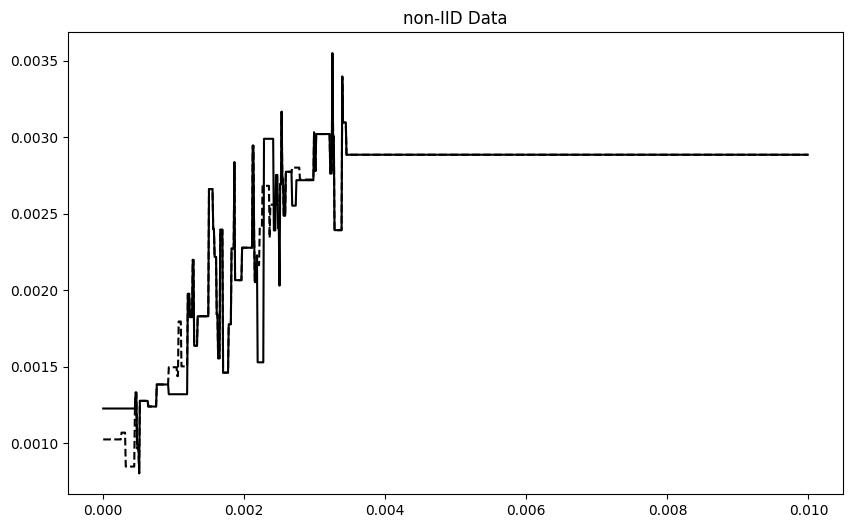

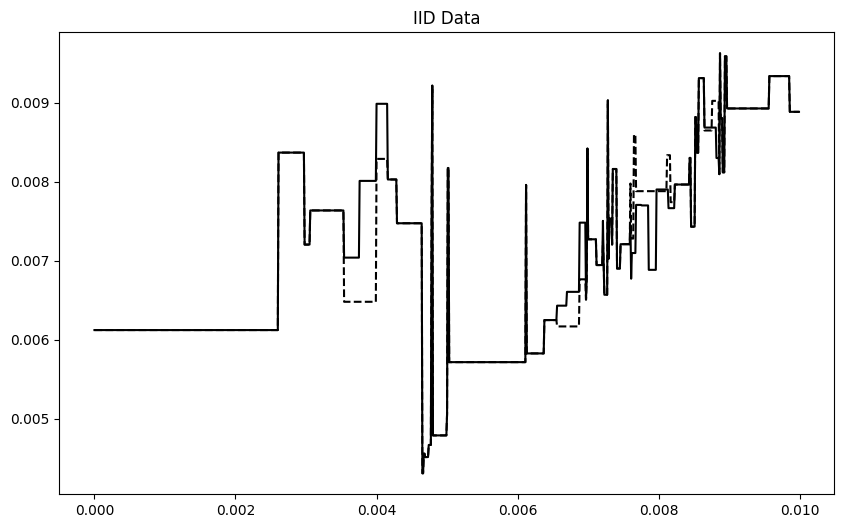

In [11]:
N_high = 2
N_low = 8

f1 = np.arange(0, 0.01, 0.00001)

plt.figure(figsize=(10, 6))

plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 0, True, v]])[0] for v in f1], color="black")
plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 0, False, v]])[0] for v in f1], '--', color="black")

plt.title('non-IID Data')

plt.show()

plt.figure(figsize=(10, 6))

plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 100, True, v]])[0] for v in f1], color="black")
plt.plot(f1, [selector_tree_f1overtime.predict([[N_high, N_low, 100, False, v]])[0] for v in f1], '--', color="black")

plt.title('IID Data')

plt.show()

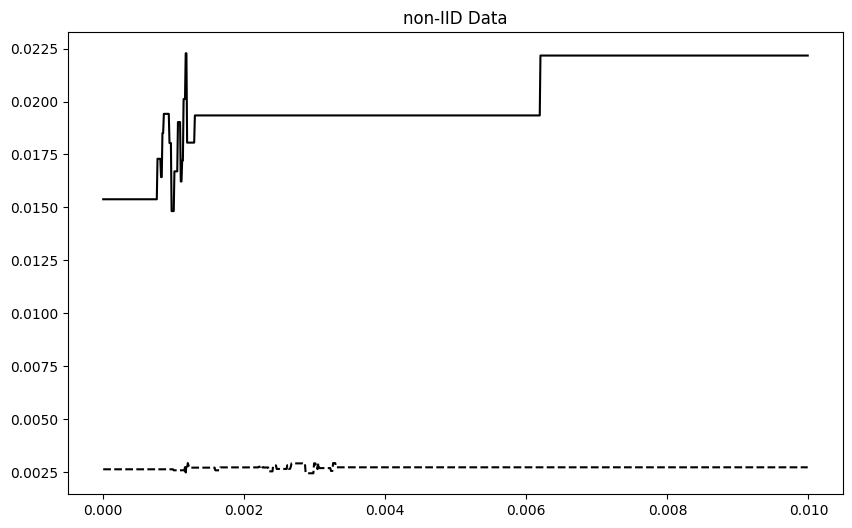

In [13]:
N_high = 4
N_low = 2

f1 = np.arange(0, 0.01, 0.00001)

plt.figure(figsize=(10, 6))

plt.plot(f1, [hdh_tree_f1overtime.predict([[1, True, 0.1, v]])[0] for v in f1], color="black")
plt.plot(f1, [hdh_tree_f1overtime.predict([[1, False, 0.1, v]])[0] for v in f1], '--', color="black")

plt.title('non-IID Data')

plt.show()

In [18]:
# Features and target
x = exp_data_selector[['High-Spec Clients', 'Low-Spec Clients', 'IID Data', 'Selector', 'FL Round', 'Previous F1/Time']]
y = exp_data_selector['F1/Time']

# Standardize input (important for GPR)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr.fit(X_train, y_train)

joblib.dump(gpr, '../predictors/bo_model.pkl')
joblib.dump(scaler, '../predictors/bo_scaler.pkl')

# Predict on test set
y_pred, sigma = gpr.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [4.00000000e+00 8.00000000e+00 0.00000000e+00 1.00000000e+00
 1.00000000e+01 2.86188385e-03] → Predicted accuracy: 0.001 ± 0.000
Input: [2.00000000e+00 4.00000000e+00 1.00000000e+02 1.00000000e+00
 1.10000000e+01 6.31896552e-03] → Predicted accuracy: 0.005 ± 0.016
Input: [1.00000000e+01 1.00000000e+01 1.00000000e+02 1.00000000e+00
 9.00000000e+00 7.70500826e-03] → Predicted accuracy: 0.007 ± 0.006
Input: [8.00000000e+00 4.00000000e+00 0.00000000e+00 1.00000000e+00
 1.80000000e+01 2.67947126e-03] → Predicted accuracy: 0.003 ± 0.006
Input: [2.00000000e+00 4.00000000e+00 1.00000000e+02 1.00000000e+00
 1.40000000e+01 7.01518438e-03] → Predicted accuracy: 0.006 ± 0.000
Input: [5.00000000e+00 5.00000000e+00 0.00000000e+00 0.00000000e+00
 2.00000000e+01 3.00900772e-03] → Predicted accuracy: -0.024 ± 0.005
Input: [8.00000000e+00 4.00000000e+00 1.00000000e+02 1.00000000e+00
 1.30000000e+01 7.05582277e-03] → Predicted accuracy: 0.007 ± 0.000
Input: [2.00000000e+00 4.00000000e+00 0.0000000

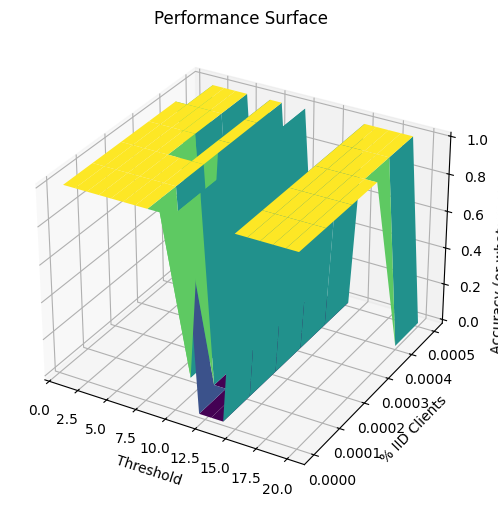

In [22]:
gpr = joblib.load('../predictors/bo_model.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0, 0.0006, 0.0001)
X, Y = np.meshgrid(rounds, f1_over_time)


def objective(policy_on, curr_round, prev_f1_overtime):  # binary: 0 or 1
    X = [[5, 5, 0, policy_on[0], curr_round, prev_f1_overtime]]
    X_scaled = scaler.transform(X)
    y_pred = -gpr.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Threshold')
ax.set_ylabel('% IID Clients')
ax.set_zlabel('Accuracy (or whatever your metric is)')
plt.title("Performance Surface")
plt.show()


In [6]:
# Features and target
x = exp_data_hdh[['FL Round', 'HDH', 'Previous JSD', 'Previous F1/Time']]
y = exp_data_hdh[['Final F1/Time']]

# Standardize input (important for GPR)
scaler_hdh = StandardScaler()
X_scaled = scaler_hdh.fit_transform(x)

# Define GPR with RBF kernel
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-1, 1e2))
gpr_hdh = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-4, normalize_y=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.7, random_state=42)

# Fit model
# WARNING!! Takes approx. 1 min to complete
gpr_hdh.fit(X_train, y_train)

joblib.dump(gpr_hdh, '../predictors/bo_model_hdh.pkl')
joblib.dump(scaler_hdh, '../predictors/bo_scaler_hdh.pkl')

# Predict on test set
y_pred, sigma = gpr_hdh.predict(X_test, return_std=True)

# Output example
for xi, pred, std in zip(X_test, y_pred, sigma):
    print(f"Input: {scaler_hdh.inverse_transform([xi])[0]} → Predicted accuracy: {pred:.3f} ± {std:.3f}")

Input: [16.          1.          0.05        0.02272122] → Predicted accuracy: 0.023 ± 0.000
Input: [1.90000000e+01 1.00000000e+00 5.00000000e-02 5.49806274e-03] → Predicted accuracy: 0.005 ± 0.000
Input: [2.00000000e+00 0.00000000e+00 8.00000000e-02 5.85847504e-04] → Predicted accuracy: 0.000 ± 0.000
Input: [5.0000000e+00 0.0000000e+00 2.2000000e-01 1.8641074e-03] → Predicted accuracy: 0.006 ± 0.008
Input: [7.00000000e+00 0.00000000e+00 8.00000000e-02 3.27727324e-03] → Predicted accuracy: 0.013 ± 0.000
Input: [8.         1.         0.05       0.01611178] → Predicted accuracy: 0.019 ± 0.000
Input: [9.         1.         0.05       0.01861331] → Predicted accuracy: 0.023 ± 0.000
Input: [1.00000000e+01 0.00000000e+00 1.50000000e-01 2.97235462e-03] → Predicted accuracy: 0.003 ± 0.000
Input: [7.00000000e+00 0.00000000e+00 1.40000000e-01 2.52727076e-03] → Predicted accuracy: 0.003 ± 0.000
Input: [9.         1.         0.05       0.01566961] → Predicted accuracy: 0.018 ± 0.000
Input: [3.0000

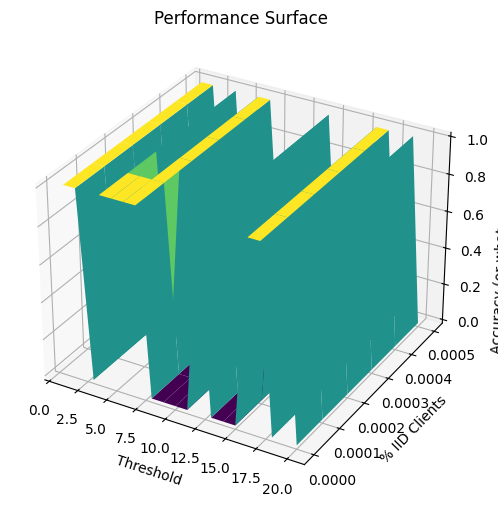

In [7]:
gpr_hdh = joblib.load('../predictors/bo_model_hdh.pkl')

rounds = np.linspace(1, 20, 20)
f1_over_time = np.arange(0, 0.0006, 0.0001)
X, Y = np.meshgrid(rounds, f1_over_time)


def objective(policy_on, curr_round, prev_f1_overtime):  # binary: 0 or 1
    X = [[curr_round, policy_on[0], 0.2, prev_f1_overtime]]
    X_scaled = scaler_hdh.transform(X)
    y_pred = -gpr_hdh.predict(X_scaled)[0]  # maximize → minimize negative
    return y_pred


Z = np.zeros_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        def wrapped_objective(policy_on):
            curr_round = X[i, j]
            prev_f1_overtime = Y[i, j]

            return objective(policy_on, curr_round, prev_f1_overtime)


        res = gp_minimize(wrapped_objective,  # objective fn
                          [(0, 1)],  # policy_on ∈ {0,1}
                          acq_func="EI",  # acquisition function
                          n_calls=10, random_state=42)

        Z[i, j] = res.x[0]

# Plot the surface
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')

ax.set_xlabel('Threshold')
ax.set_ylabel('% IID Clients')
ax.set_zlabel('Accuracy (or whatever your metric is)')
plt.title("Performance Surface")
plt.show()
